# 2D Discrete Fourier Transform

The goal of this short tutorial is to gain intuition about the 2D [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform). We recommend to play with the notebook. In the following, we will define a grayscale image of $M \times N$ pixels as a function
$$
\begin{align}
	f & : \{0, \ldots, M-1\} \times \{0, \ldots, N-1\} \longrightarrow \mathbb{R} \\
	& (m, n) \longmapsto f(m, n)
\end{align}
$$

We will use a [Sentinel-2](https://dataspace.copernicus.eu/data-collections/copernicus-sentinel-data/sentinel-2) (ESA, Copernicus) image (the blue channel only) throughout the tutorial for examples. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Image shape:  (128, 128)


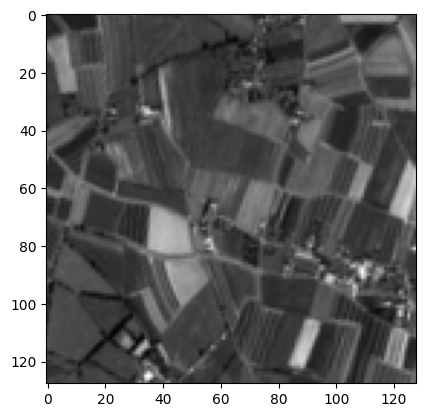

In [2]:
image = np.load('s2_band.npy')
print('Image shape: ', image.shape) 

fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
plt.show()

The 2D discrete Fourier transform of $f$ is a complex image $F$ of size $M \times N$:
\begin{aligned}
	F & : \{0, \ldots, M-1\} \times \{0, \ldots, N-1\} \longrightarrow \mathbb{C} \\
	& (u,v) \longmapsto \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} f(m,n) e^{-j2\pi \large(\frac{um}{M} + \frac{vn}{N}\large)}
\end{aligned}
In practice, the Fast Fourier Transform (FFT) [1] algorithm is used. It is, for instance, implemented in numpy: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#r8913bc1f0021-ct.

[1] Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301.

Fourier transform shape:  (128, 128)


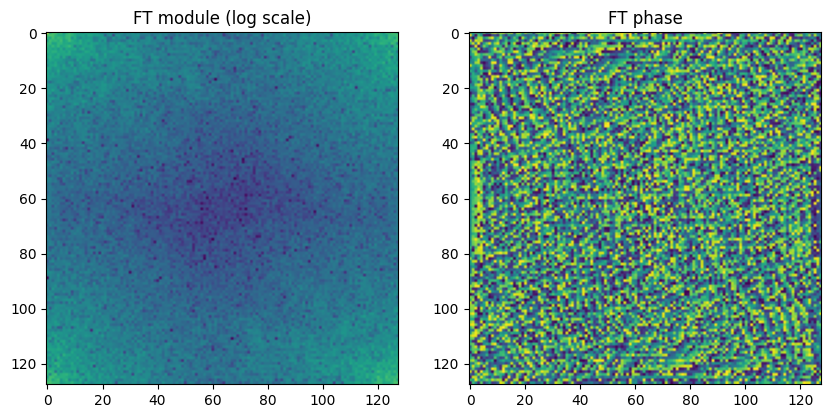

In [3]:
fourier_transform = np.fft.fft2(image)
print('Fourier transform shape: ', fourier_transform.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.log(np.abs(fourier_transform) + 1e-9))
ax[0].set_title('FT module (log scale)')
ax[1].imshow(np.angle(fourier_transform))
ax[1].set_title('FT phase')
plt.show()

The Fourier transform has indeed the same dimensions as the image. The first and middle rows correspond, respectively, to the lowest and highest spatial frequencies on the vertical axis. In the same way, the first and middle columns correspond, respectively, to the lowest and highest spatial frequencies on the horizontal axis. 

The top-left pixel $F(u=0,v=0)$ of the Fourier transform corresponds to the center-frequency component. The center pixel  $F(u=M/2, v=N/2)$ corresponds to the maximum resolved frequencies, also called the Nyquist frequencies, fixed by the sampling distance $d$ between two pixels:
$$
    f_{max} = \frac{1}{2 \times d}.
$$
Usually, the zero-frequency component is shifted at the center of the spectrum for vizualization purposes. This is what the `np.fft.fftshift` function does: https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html.

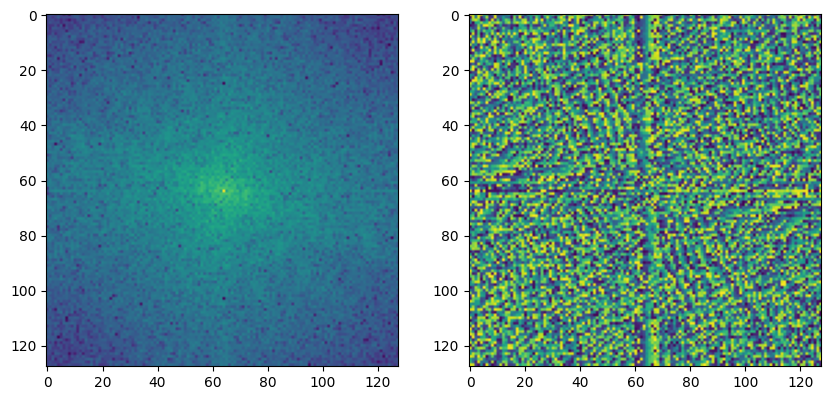

In [4]:
fourier_transform = np.fft.fftshift(np.fft.fft2(image))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.log(np.abs(fourier_transform) + 1e-9))
ax[1].imshow(np.angle(fourier_transform))
plt.show()

#### The 2D Discrete Fourier Transform: a change of basis

The idea behind the 2D discrete Fourier transform is that the image can be decomposed into a sum of sine waves. In other words, the discrete Fourier transform can be viewed as a change of basis, from the canonical basis to the Fourier basis, that comprises sine waves.

Let's denote $(E_{m,n})_{ij} = \begin{cases} 1 & \text{if } i = m \text{ and } j = n, \\ 0 & \text{ otherwise.} \end{cases} \:\:\: $ the canonical basis matrix. We can write the image as 

\begin{aligned}
        I = 
		\begin{bmatrix}
		f(1,1) & \ldots & f(1, N) \\
		\vdots & & \vdots \\
		f(M, 1) & \ldots & f(M, N)
	\end{bmatrix}
	& = f(1,1) \begin{bmatrix}
		1 & \ldots & 0 \\
		\vdots & & \vdots \\
		0 & \ldots & 0
	\end{bmatrix}
	+ \ldots + f(1, N) \begin{bmatrix}
		0 & \ldots & 1 \\
		\vdots & & \vdots \\
		0 & \ldots & 0
	\end{bmatrix} + \ldots 
	+ f(M,1) \begin{bmatrix}
		0 & \ldots & 0 \\
		\vdots & & \vdots \\
		1 & \ldots & 0
	\end{bmatrix}
	+ \ldots + f(M, N) \begin{bmatrix}
		0 & \ldots & 0 \\
		\vdots & & \vdots \\
		0 & \ldots & 1
	\end{bmatrix} \\ 
	& = \sum_{m=1}^M \sum_{n=1}^N f(m,n) E_{m,n}.
\end{aligned}

The image is the sum of the canonical basis matrices weighted by the pixel values.

In [5]:
class CanonicalBasis:
    """Canonical basis for a M x N image."""
    def __init__(self, M, N):
        self.M = M
        self.N = N
        
    def __call__(self, x, y):
        base_matrix = np.zeros((self.M, self.N))
        base_matrix[x, y] = 1
        return base_matrix

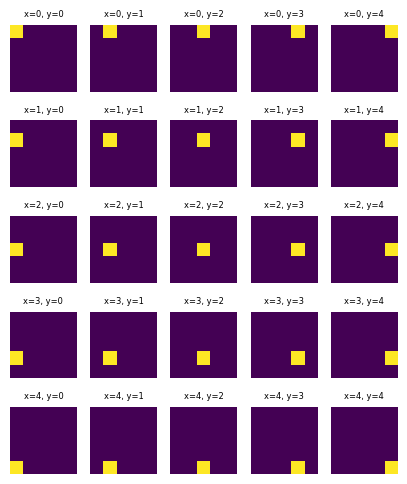

In [22]:
canonical_basis = CanonicalBasis(5, 5)

fig, ax = plt.subplots(5, 5, figsize=(5, 6))

for x in range(0, 5):
    for y in range(0, 5):
        base_matrix = canonical_basis(x, y)
        ax[x, y].imshow(base_matrix)
        ax[x, y].axis('off')
        ax[x, y].set_title(f'x={x}, y={y}', fontsize=6)
plt.show()

Using the inverse Fourier transform, we can write each pixel as
$$
	f(m,n) = \frac{1}{MN} \sum_{u=1}^M \sum_{v=1}^N F(u,v) e^{j2\pi \large(\frac{(u-1)m}{M} + \frac{(v-1)n}{N}\large)}.
$$

Plugging $f(m,n)$ into the equation above leads to
\begin{aligned}
    I = \frac{1}{MN} & \sum_{m=1}^M \sum_{n=1}^N \sum_{u=1}^M \sum_{v=1}^N F(u,v) e^{j2\pi \large(\frac{(u-1)m}{M} + \frac{(v-1)n}{N}\large)} E_{m,n} \\
	& = 
	F(1,1) \frac{1}{MN} \sum_{m=1}^M \sum_{n=1}^N E_{m,n}  + \ldots 
	+ F(M,N) \frac{1}{MN} \sum_{m=1}^M \sum_{n=1}^N e^{j2\pi \large(\frac{(M-1)m}{M} + \frac{(N-1)n}{N}\large)} E_{m,n} \\
	& = F(1,1) \frac{1}{MN} \mathbf{1}_{M \times N}
	+ \ldots
	+ F(M,N) \frac{1}{MN} \begin{bmatrix}
		e^{j2\pi \large(\frac{(M-1)m}{M} + \frac{(N-1)n}{N}\large)}
	\end{bmatrix}_{\substack{m=1,\ldots,M \\ n=1,\ldots,N}}.
\end{aligned}
The image is the sum of the Fourier basis matrices weighted by the Fourier coefficients.

Note that we used a slight change of notation ($N \leftarrow N + 1$ and $M \leftarrow M + 1$).

In [7]:
class FourierBasis:
    """Fourier basis for a M x N image."""
    def __init__(self, M, N):
        self.M = M
        self.N = N
        self.xx, self.yy = np.meshgrid(np.arange(M), np.arange(N))

    def __call__(self, u, v):
        x = 2 * np.pi * (u * self.xx / self.M + v * self.yy / self.N)
        real_part = np.cos(x)
        imag_part = np.sin(x)
        return real_part, imag_part

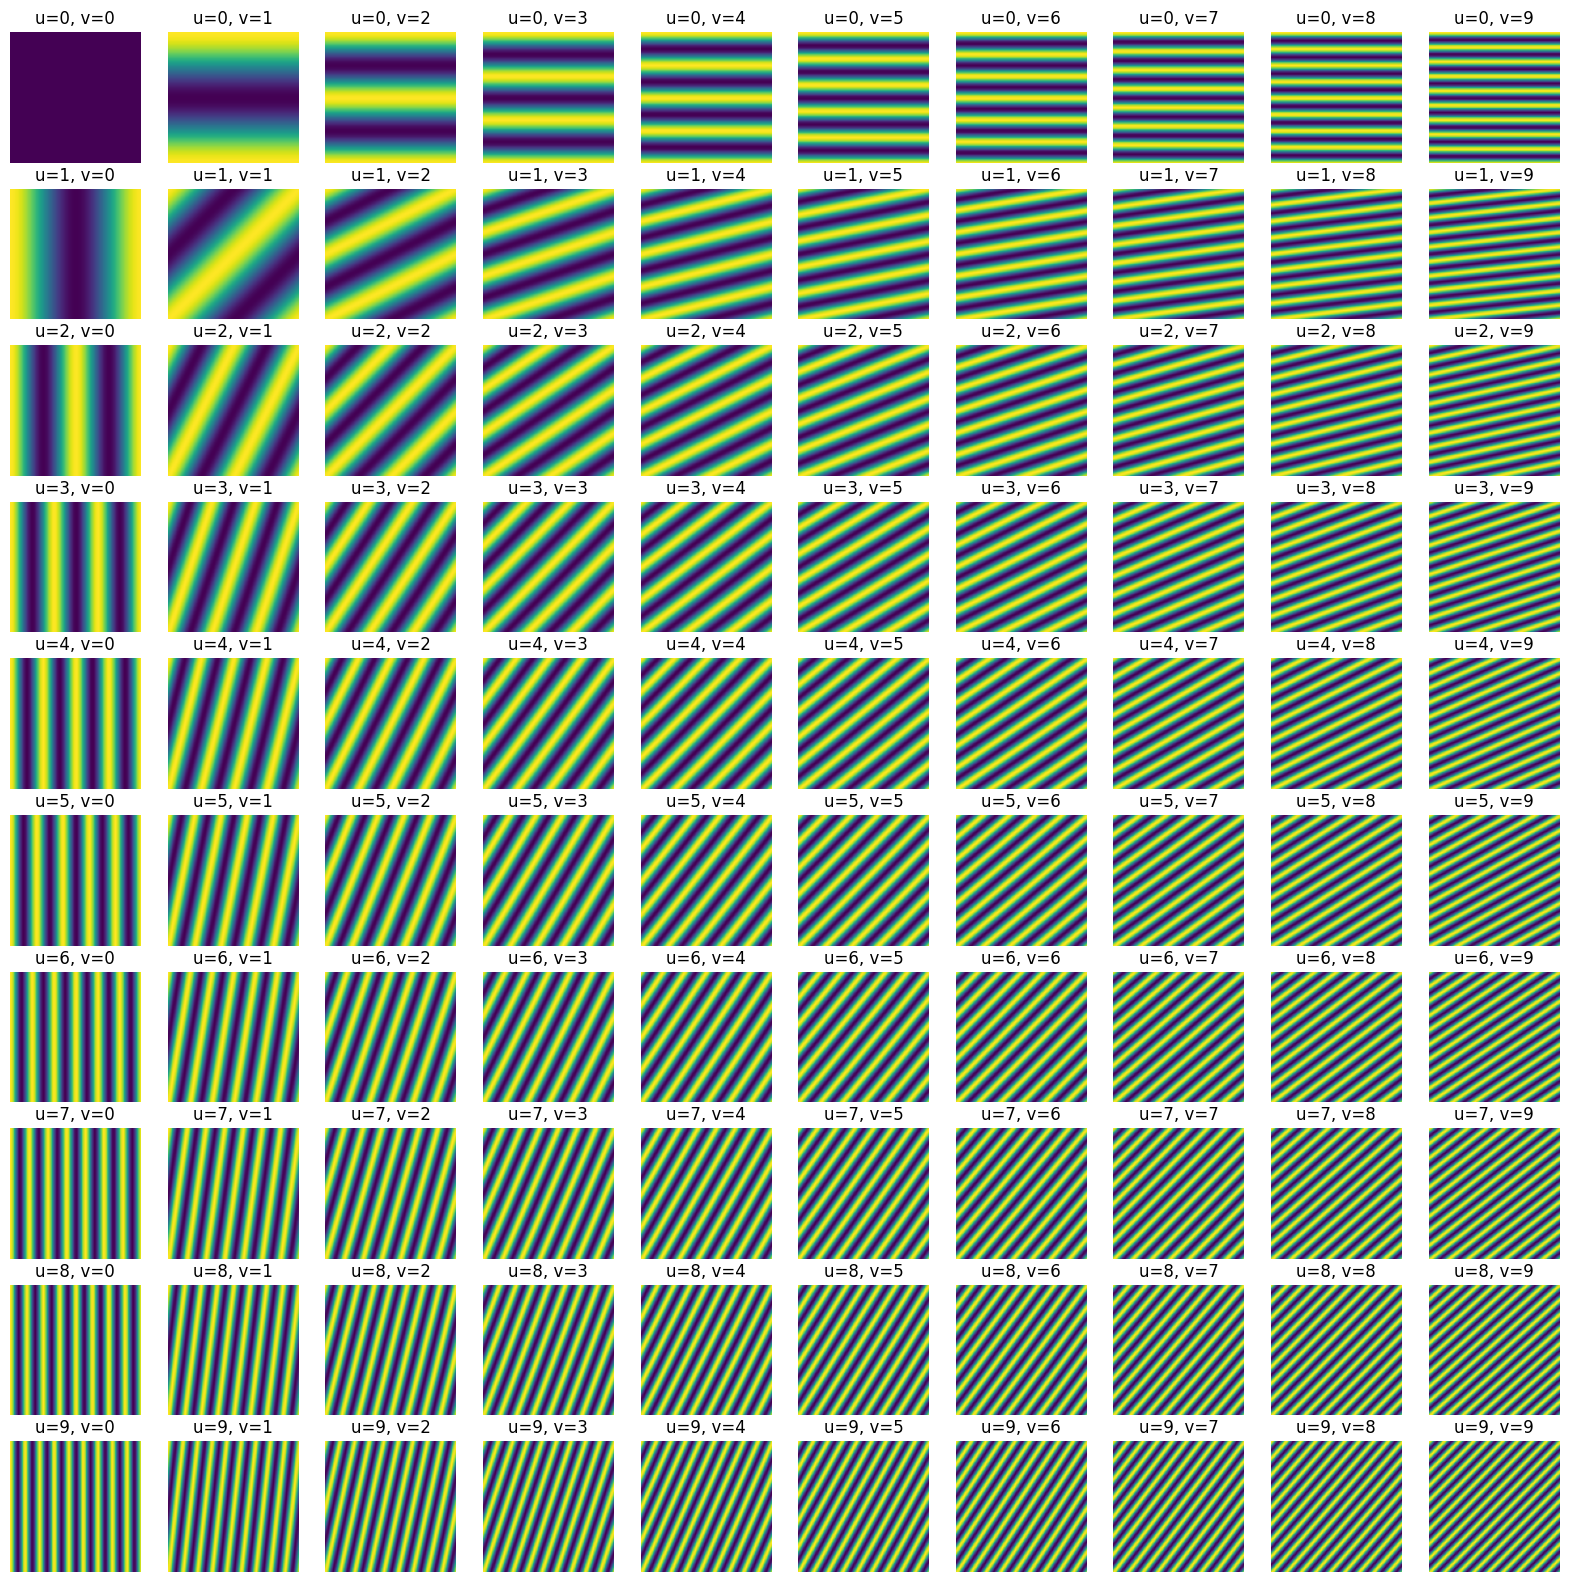

In [8]:
fourier_basis = FourierBasis(100, 100)

fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for u in range(0, 10):
    for v in range(0, 10):
        vec1_real, _ = fourier_basis(u, v)
        ax[u, v].imshow(vec1_real)
        ax[u, v].axis('off')
        ax[u, v].set_title(f'u={u}, v={v}', fontsize=12)
plt.show()

#### Image processing in the Fourier space

Many fast and efficient signal processing algorithms are based on processing in the Fourier space. For instance, in remote sensing, [banding](https://www.usgs.gov/landsat-missions/banding) is a geometric and radiometric anomaly that can be caused by various preprocessing errors. Banding can be corrected in the Fourier space, and inversely, it can easily be simulated by parsimoniously altering the Fourier space, as in the example below.

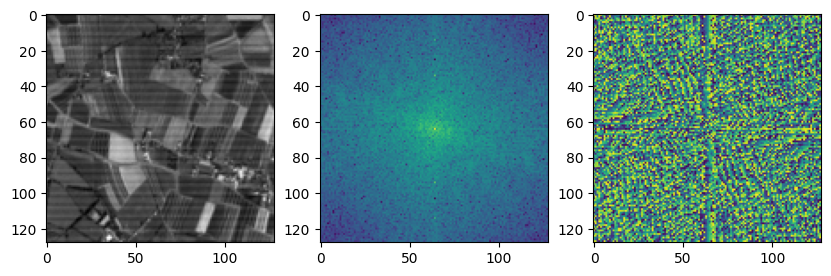

In [9]:
# Banding

center = fourier_transform.shape[0] // 2

banding_fourier_transform = np.fft.fftshift(np.fft.fft2(image))

banding_fourier_transform[center - 30, center] *= np.exp(5)
banding_fourier_transform[center + 30, center] *= np.exp(5)
banding_fourier_transform[center - 50, center] *= np.exp(3)
banding_fourier_transform[center + 50, center] *= np.exp(3)

banding_image = np.abs(np.fft.ifft2(banding_fourier_transform))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(banding_image, cmap='gray')
ax[1].imshow(np.log(np.abs(banding_fourier_transform) + 1e-9))
ax[2].imshow(np.angle(banding_fourier_transform))
plt.show()

Low-pass and high-pass filters are simply matrix multiplication in the Fourier space.

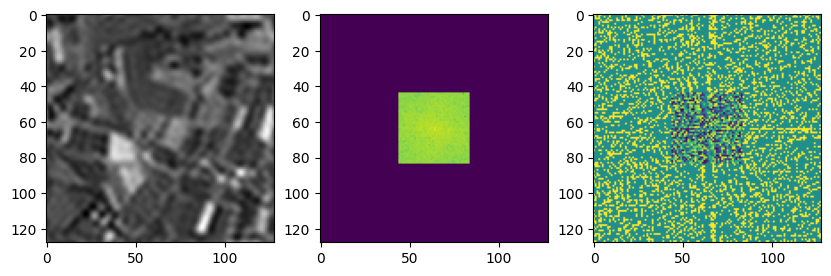

In [10]:
# Low-pass filtering

threshold = 20
low_pass = np.zeros_like(fourier_transform)
low_pass[center - threshold : center + threshold, center - threshold : center + threshold] = 1

low_freq_fourier = fourier_transform * low_pass
low_freq_img = np.abs(np.fft.ifft2(low_freq_fourier))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(low_freq_img, cmap='gray')
ax[1].imshow(np.log(np.abs(low_freq_fourier) + 1e-9))
ax[2].imshow(np.angle(low_freq_fourier))
plt.show()

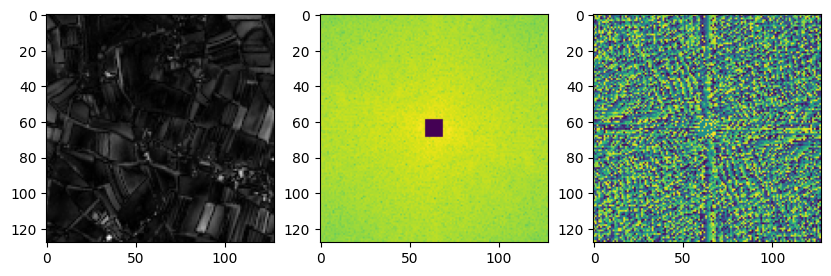

In [11]:
# High-pass filtering

threshold = 5
high_pass = np.ones_like(fourier_transform)
high_pass[center - threshold : center + threshold, center - threshold : center + threshold] = 0

high_freq_fourier = fourier_transform * high_pass
high_freq_img = np.abs(np.fft.ifft2(high_freq_fourier))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(high_freq_img, cmap='gray')
ax[1].imshow(np.log(np.abs(high_freq_fourier) + 1e-9))
ax[2].imshow(np.angle(high_freq_fourier))
plt.show()

#### Pixel size is not resolution

In the following, we show by an example that we can decrease the pixel size while resolution remains constant. Artificially increasing the Fourier space by adding zeroes beyond the Nyquist frequency increases the image size but do not increase the amount of information. Patterns whose frequency exceeds the maximum frequency of the original image will still not be detected.

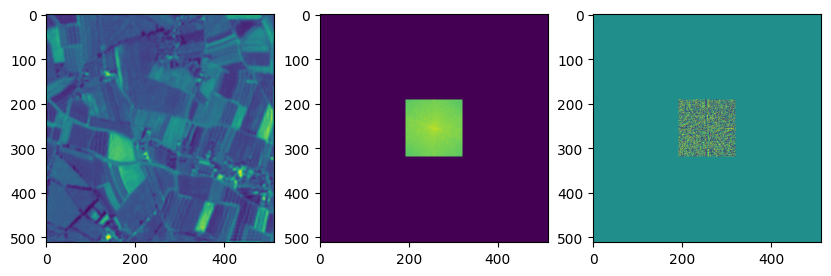

In [12]:
up_scale = 4
img_shape = image.shape
up_img_shape = (img_shape[0] * up_scale, img_shape[1] * up_scale)
n_rows = up_img_shape[0] - img_shape[0]
n_cols = up_img_shape[1] - img_shape[1]

up_fourier_transform = np.concatenate((np.zeros((n_rows // 2, img_shape[0])), fourier_transform), axis=0)
up_fourier_transform = np.concatenate((up_fourier_transform, np.zeros((n_rows // 2, img_shape[0]))), axis=0)
up_fourier_transform = np.concatenate((up_fourier_transform, np.zeros((up_img_shape[0], n_cols // 2))), axis=1)
up_fourier_transform = np.concatenate((np.zeros((up_img_shape[0], n_cols // 2)), up_fourier_transform), axis=1)

up_image = np.fft.ifft2(up_fourier_transform)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(np.abs(up_image))
ax[1].imshow(np.log(np.abs(up_fourier_transform) + 1e-9))
ax[2].imshow(np.angle(up_fourier_transform))
plt.show()

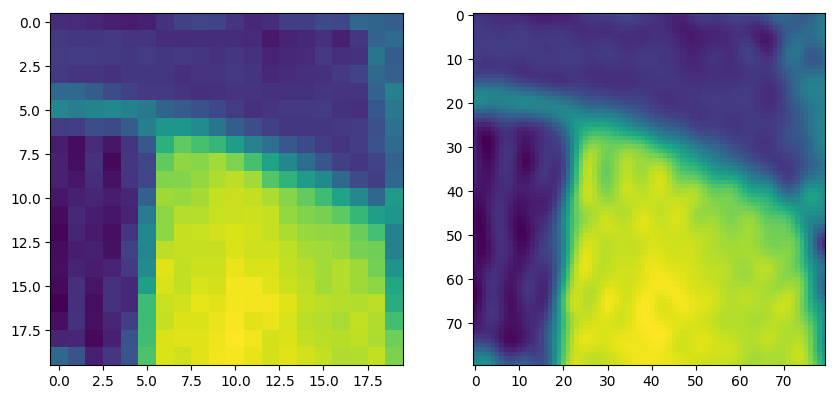

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image[60:80, 30:50])
ax[1].imshow(np.abs(up_image[240:320, 120:200]))
plt.show()

On the contrary, the truncation of the Fourier space downscales the image.

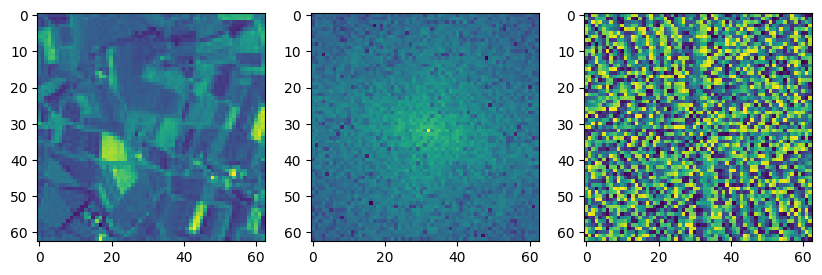

In [14]:
down_scale = 2

down_fourier_transform = fourier_transform[center -  fourier_transform.shape[0] // (2 * down_scale) : center + fourier_transform.shape[0] // (2 * down_scale) - 1]
down_fourier_transform = down_fourier_transform[:, center -  fourier_transform.shape[0] // (2 * down_scale) : center + fourier_transform.shape[0] // (2 * down_scale) - 1]

down_image = np.fft.ifft2(down_fourier_transform)

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(np.abs(down_image))
ax[1].imshow(np.log(np.abs(down_fourier_transform) + 1e-9))
ax[2].imshow(np.angle(down_fourier_transform))
plt.show()

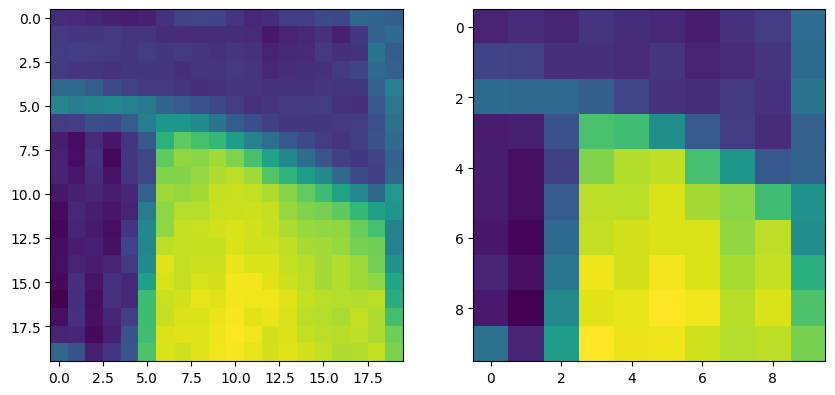

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image[60:80, 30:50])
ax[1].imshow(np.abs(down_image[30:40, 15:25]))
plt.show()